# Topic Modelling with LDA   
In this notebook we will use the `gensim` library to perform topic modelling task and find out what are the sarcasm headlines database are about.  We will use the cleaned tokens saved from Notebook 1 as input for our models.  
 

**Outline**  
- Create bag of words and tf-idf representations for the documents  
- Use LDA model to do topic modelling  
- Analyse and visualise topic results  


**Estimated time:** 
 30 mins

In [1]:
### Change notebook directory, for Gadi environment only
import os
working_path = os.path.expandvars("/scratch/vp91/$USER/AI-ML-Applications-Natural-Language-Processing/")
os.chdir(working_path)
data_path = '/scratch/vp91/NLP-2023/data/'
model_path = '/scratch/vp91/NLP-2023/model/'

In [2]:
# local paths
# working_path = './'
# data_path = '../data/'
# model_path = '../model/'

In [3]:
import gensim
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from nltk import word_tokenize

#  Use log to make sure that by the final passes, most of the documents have converged. 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pickle
from pprint import pprint
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 

2023-09-11 20:04:14,591 : INFO : Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-09-11 20:04:14,594 : INFO : Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


## Load Tokens from Headlines Dataset 
Now we still use the smaller data and feed the clean tokens to `Dictionary` class. 

<div class="alert alert-block alert-info">
Remember, if you want to use your own dataset, you need to do the text preprocess like notebook 1 demonstrates before feeding them to the model.
</div>  


In [4]:
data = pd.read_json(data_path + 'Sarcasm_Headlines_Dataset_v2.json',lines=True)
data
# load our tokens back
with open(working_path + 'tokens.pkl', 'rb') as f:
    tokens = pickle.load(f)
print(len(tokens),tokens[:10])

28619 [['thirtysomething', 'scientist', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep', 'totally', 'nail', 'congress', 'falling', 'short', 'gender', 'racial', 'equality'], ['eat', 'veggie', 'deliciously', 'different', 'recipe'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'come', 'pretty', 'close', 'using', 'word', 'streaming', 'correctly'], ['white', 'inheritance'], ['way', 'file', 'tax', 'le', 'stress'], ['richard', 'bransons', 'globalwarming', 'donation', 'nearly', 'much', 'cost', 'failed', 'balloon', 'trip'], ['shadow', 'government', 'getting', 'large', 'meet', 'marriott', 'conference', 'room', 'b'], ['lot', 'parent', 'know', 'scenario']]


## Add Bi-grams
The result of topic models are weighted tokens for each topic and weighted topic for each document. There is NO topic name from the model, only topic indexes. So it is up to us to understand and explain the topic results.  

One way to help us with that is to creat n-grams for our tokens.  

N-grams means a phrase made of n words. This will show us the frequently occurred phrases and help us to qualitively understand the topic results.

In [5]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(tokens, min_count=20)
for idx in range(len(tokens)):
    for token in bigram[tokens[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            tokens[idx].append(token)

2023-09-11 20:04:25,577 : INFO : collecting all words and their counts
2023-09-11 20:04:25,579 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-09-11 20:04:25,663 : INFO : PROGRESS: at sentence #10000, processed 71639 words and 70114 word types
2023-09-11 20:04:25,764 : INFO : PROGRESS: at sentence #20000, processed 143015 words and 126220 word types
2023-09-11 20:04:25,838 : INFO : collected 170925 token types (unigram + bigrams) from a corpus of 204464 words and 28619 sentences
2023-09-11 20:04:25,839 : INFO : merged Phrases<170925 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2023-09-11 20:04:25,843 : INFO : Phrases lifecycle event {'msg': 'built Phrases<170925 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.27s', 'datetime': '2023-09-11T20:04:25.843936', 'gensim': '4.1.2', 'python': '3.7.4 (default, Nov  6 2019, 12:34:08) \n[GCC 8.2.1 20180905 (Red Hat 8.2.1-3)]', 'platform': 'Linux-4.18.0-477.15.1.el8.nci.x86_64-x86_64-w

In [6]:
tokens[:5]

[['thirtysomething',
  'scientist',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep',
  'totally',
  'nail',
  'congress',
  'falling',
  'short',
  'gender',
  'racial',
  'equality'],
 ['eat', 'veggie', 'deliciously', 'different', 'recipe'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'come',
  'pretty',
  'close',
  'using',
  'word',
  'streaming',
  'correctly']]

## Create Input    
Using the `Dictionary` class of the library, we can easily filter the words with extremely low or high frequency counts.

In [7]:
%%time
texts = tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
# remove gaps in id sequence after words that were removed
dictionary.compactify()  



2023-09-11 20:04:26,249 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-09-11 20:04:26,384 : INFO : adding document #10000 to Dictionary(15037 unique tokens: ['clock', 'doomsday', 'hair', 'loss', 'scientist']...)
2023-09-11 20:04:26,522 : INFO : adding document #20000 to Dictionary(21246 unique tokens: ['clock', 'doomsday', 'hair', 'loss', 'scientist']...)
2023-09-11 20:04:26,645 : INFO : built Dictionary(25178 unique tokens: ['clock', 'doomsday', 'hair', 'loss', 'scientist']...) from 28619 documents (total 208518 corpus positions)
2023-09-11 20:04:26,646 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(25178 unique tokens: ['clock', 'doomsday', 'hair', 'loss', 'scientist']...) from 28619 documents (total 208518 corpus positions)", 'datetime': '2023-09-11T20:04:26.646529', 'gensim': '4.1.2', 'python': '3.7.4 (default, Nov  6 2019, 12:34:08) \n[GCC 8.2.1 20180905 (Red Hat 8.2.1-3)]', 'platform': 'Linux-4.18.0-477.15.1.el8.nci.x86_64-x86_64-with-centos-8.

CPU times: user 441 ms, sys: 2.71 ms, total: 444 ms
Wall time: 442 ms


<div class="alert alert-block alert-info">

Right click on the left side of the output, select **Enable Scrolling for Outputs**
</div>  

### Vectorization  
Now we vectorize the documents using 2 different frequency counts. Bag-of-words, which is the total frequency count in the corpus, and tf-idf, which is capable of highlighting the uniqueness of a word in relation to the document and the corpus.

In [8]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in texts]

In [9]:
# tf-idf representation of the documents
## train the tfidf model
tfidf = TfidfModel(corpus) 
### apply the model to whole corpus
corpus_tfidf = tfidf[corpus]

2023-09-11 20:04:26,843 : INFO : collecting document frequencies
2023-09-11 20:04:26,844 : INFO : PROGRESS: processing document #0
2023-09-11 20:04:26,852 : INFO : PROGRESS: processing document #10000
2023-09-11 20:04:26,860 : INFO : PROGRESS: processing document #20000
2023-09-11 20:04:26,871 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 28619 documents and 2119 features (136930 matrix non-zeros)', 'datetime': '2023-09-11T20:04:26.871860', 'gensim': '4.1.2', 'python': '3.7.4 (default, Nov  6 2019, 12:34:08) \n[GCC 8.2.1 20180905 (Red Hat 8.2.1-3)]', 'platform': 'Linux-4.18.0-477.15.1.el8.nci.x86_64-x86_64-with-centos-8.8-Green_Obsidian', 'event': 'initialize'}


In [10]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2119
Number of documents: 28619


## Training LDAMulticore  
Here we use the `LdaMulticore` class to distribute the training on multiple workers.  

`num_topics`  
Now we are ready to train the model. But how many topics should we define? It really depends on your data and your interpretation. Let's start trying with 10 topics and see what the results are like.  

`chunksize`  
It controls how many documents are processed each time for training. For example, it the chunksize is the size of the corpus, then the model will process them in one go. 
<div class="alert alert-block alert-info">
Becareful when increasing the chunksize, because it needs to fit in memory. 
</div>   

`passes`   
It is equivalent to `epoch` in neural network, specifing how many times we want to go over the corpus.  


`iterations`  
This controls how many times we want to learn each document. High iterations and passes usually improve the result.  

`eval_every`  
This will evaluate model log perplexity every n updates. Setting to 1 will slow down the training by 2x. 

`alpha`  
This is A-priori belief on document-topic distibution. Can also be 1D array of length equal to num_topics to denote an asymmetric user defined prior for each topic.  

`eta`  
This is A-prior belief on topic-word distribution. `auto` learns an asymmetric prior from the corpus.  



In [11]:
%%time
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 5
iterations = 20
eval_every = 1  
alpha = 'symmetric'
eta = 'auto'

# Build LDA model
lda = LdaMulticore(corpus=corpus, id2word=dictionary,num_topics=num_topics, 
                   workers = 20,
                   chunksize=chunksize, passes=passes, iterations=iterations, 
                   alpha=alpha, eta = eta,
#                    decay=0.9,
                   # Topics with a probability lower than this threshold will be filtered out.
#                    minimum_probability=0.5,
                   # for reproducibility.
#                    random_state=100,
                   # If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word, along with their phi values multiplied by the feature length (i.e. word count).
#                    per_word_topics=True,
                   # if per_word_topics is True, this represents a lower bound on the term probabilities.
#                    minimum_phi_value = 0.5,
                  )

ldatopics = [[word for word, prob in topic] for topicid, topic in lda.show_topics(formatted=False)]
coh= CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, coherence = 'u_mass')
print('\nPerplexity: ', lda.log_perplexity(corpus))
print('\nCoherence Score: ', coh.get_coherence())


2023-09-11 20:04:26,895 : INFO : using symmetric alpha at 0.1
2023-09-11 20:04:26,896 : INFO : using serial LDA version on this node
2023-09-11 20:04:26,931 : INFO : running online LDA training, 10 topics, 5 passes over the supplied corpus of 28619 documents, updating every 40000 documents, evaluating every ~28619 documents, iterating 20x with a convergence threshold of 0.001000
2023-09-11 20:04:26,932 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-09-11 20:04:26,939 : INFO : training LDA model using 20 processes
2023-09-11 20:04:27,100 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/28619, outstanding queue size 1
2023-09-11 20:04:27,108 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/28619, outstanding queue size 2
2023-09-11 20:04:27,110 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/28619, outstanding queue size 3
2023-09-1


Perplexity:  -7.73593930936192

Coherence Score:  -4.790299612415307
CPU times: user 9.33 s, sys: 325 ms, total: 9.66 s
Wall time: 22.2 s


In [12]:
%%time
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 5
iterations = 20
update_every=1
eval_every = 1  
alpha = 'symmetric'
eta = 'auto'

# Build LDA model
lda_tfidf = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary,num_topics=num_topics, 
                   workers = 20,
                   chunksize=chunksize, passes=passes, iterations=iterations, 
                   alpha=alpha, eta = eta,
#                    decay=0.9,
#                    minimum_probability=0.5,
#                    minimum_phi_value = 0.5,
#                    random_state=100,
#                    per_word_topics=True
                  )

lda_tfidf_topics = [[word for word, prob in topic] for topicid, topic in lda_tfidf.show_topics(formatted=False)]
coh_ifidf = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, coherence = 'u_mass')
print('\nPerplexity: ', lda.log_perplexity(corpus))
print('\nCoherence Score: ', coh.get_coherence())


2023-09-11 20:04:49,109 : INFO : using symmetric alpha at 0.1
2023-09-11 20:04:49,111 : INFO : using serial LDA version on this node
2023-09-11 20:04:49,114 : INFO : running online LDA training, 10 topics, 5 passes over the supplied corpus of 28619 documents, updating every 40000 documents, evaluating every ~28619 documents, iterating 20x with a convergence threshold of 0.001000
2023-09-11 20:04:49,115 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-09-11 20:04:49,116 : INFO : training LDA model using 20 processes
2023-09-11 20:04:49,326 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/28619, outstanding queue size 1
2023-09-11 20:04:49,399 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/28619, outstanding queue size 2
2023-09-11 20:04:49,500 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/28619, outstanding queue size 3
2023-09-1


Perplexity:  -7.735831263169292

Coherence Score:  -4.790299612415307
CPU times: user 14 s, sys: 363 ms, total: 14.3 s
Wall time: 20.9 s


## Result Analysis  
### Topic Coherence

Now we use the `top_topics()` function to get the coherence score for each topic. This function implements `Umass` measure and lower values means better coherence.   

In [13]:
top_topics = lda.top_topics(corpus, coherence='u_mass')

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2023-09-11 20:05:10,011 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-09-11 20:05:10,015 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-09-11 20:05:10,020 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-09-11 20:05:10,023 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-09-11 20:05:10,027 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-09-11 20:05:10,031 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-09-11 20:05:10,034 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-09-11 20:05:10,039 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-09-11 20:05:10,041 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-09-11 20:05:10,046 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-09-11 20:05:10,049 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-09-11 20:05:10

Average topic coherence: -6.5891.
[([(0.018552054, 'man'),
   (0.017584963, 'one'),
   (0.0159145, 'area'),
   (0.011129366, 'day'),
   (0.009393809, 'time'),
   (0.009352728, 'new'),
   (0.008126058, 'area_man'),
   (0.0071248524, 'woman'),
   (0.0069461847, 'get'),
   (0.0065667625, 'say'),
   (0.006178834, 'make'),
   (0.0060491413, 'state'),
   (0.0054740314, 'american'),
   (0.004919002, 'car'),
   (0.004895268, 'real'),
   (0.0046796403, 'best'),
   (0.004609286, 'year'),
   (0.004577323, 'way'),
   (0.004387347, 'still'),
   (0.00429333, 'fan')],
  -5.130785454864281),
 ([(0.017029472, 'trump'),
   (0.012276097, 'back'),
   (0.008918879, 'man'),
   (0.008914273, 'new'),
   (0.008206327, 'campaign'),
   (0.008167798, 'gop'),
   (0.008012805, 'people'),
   (0.007973432, 'house'),
   (0.0077741775, 'like'),
   (0.0075934017, 'day'),
   (0.0067062345, 'child'),
   (0.00650732, 'report'),
   (0.006026644, 'white'),
   (0.005730115, 'get'),
   (0.0056594866, 'first'),
   (0.0055318386

> **Think**  
> Can you interprete each topic based on the top words?  

### Topic Coherence Distribution

2023-09-11 20:05:10,157 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-09-11 20:05:10,161 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-09-11 20:05:10,164 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-09-11 20:05:10,167 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-09-11 20:05:10,171 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-09-11 20:05:10,174 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-09-11 20:05:10,176 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-09-11 20:05:10,179 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-09-11 20:05:10,182 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-09-11 20:05:10,185 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-09-11 20:05:10,191 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-09-11 20:05:10

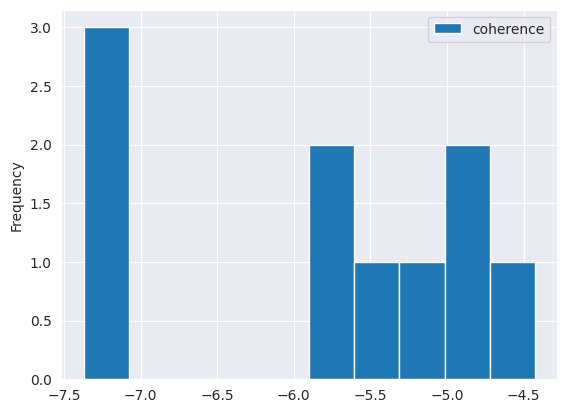

In [14]:
# number of top words in each topic to use
topw =15
topic_coh = lda.top_topics(corpus=corpus, texts=texts, dictionary=dictionary, 
    window_size=None, coherence='u_mass', topn=topw, processes=- 1)
tt=[]
c=[]
for e in topic_coh:
    tt.append(e[0])
    c.append(e[1])

df_tt = pd.DataFrame(tt)
df_coh = pd.DataFrame(c)
df_coh.rename(columns={0:'coherence'},inplace=True)
# pd.concat([df_tt,df_coh],axis=1)
df_coh = df_coh.merge(df_tt,left_index=True,right_index=True)
df_coh
df_coh.plot.hist()

> **Think**  
> How is the quality of the topics?

### Document-Topic Representation
Sorted by topic probabilities

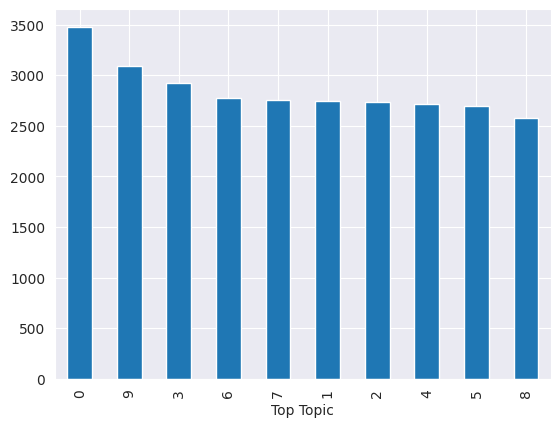

In [15]:
# get doc topic info from array
dt = lda.get_document_topics(bow = corpus, minimum_probability=0, minimum_phi_value=None, per_word_topics=False)
dt = [sorted(e,key = lambda x: x[1],reverse=True) for e in dt ]
df_t = pd.DataFrame(dt).rename({0:'Top Topic'},axis=1)
df_t3 = df_t.loc[:,:2]
# get top topicID from tuple
top=[]
for doc in dt:
    top.append(doc[0][0])
df_top = pd.DataFrame(top)

df_DT = data
df_DT = pd.merge(df_t3,df_DT,how='outer',left_index=True, right_index=True)
# # print(list(df_DT.columns.values))
# df_DT = df_DT[['Top Topic', 1, 2, 'title', 'clean_abs','_id','DOI','indexed.date-time', 'created.date-time', 'deposited.date-time', 'container-title', 'indexed.month', 'created.month', 'deposited.month', 'Fiscal', 'language']]
df_DT = pd.merge(df_top,df_DT,how='outer',left_index=True, right_index=True)
df_DT.rename(columns={0:'Top Topic','Top Topic':0},inplace=True)
df_DT
df_DT.groupby('Top Topic')['headline'].nunique().sort_values(ascending=False).plot(kind='bar')

> **Think**  
> How are documents distributed?  
> If you know the corpus, is the distribution consistant with your understanding?  
> Can this help us to change any hyperparameter?


### Topic-Word Representation
Ordered word probabilities in each topic

In [16]:
# rows -> topics
tw = lda.print_topics(num_topics=-1, num_words=15)
t = []
for i in range(num_topics):
    t.append(lda.show_topic(i,topw))
pd.DataFrame(t)

2023-09-11 20:05:17,117 : INFO : topic #0 (0.100): 0.010*"report" + 0.010*"u" + 0.010*"still" + 0.010*"go" + 0.009*"nation" + 0.009*"year" + 0.009*"woman" + 0.007*"little" + 0.006*"could" + 0.006*"say" + 0.006*"high" + 0.006*"school" + 0.005*"life" + 0.005*"want" + 0.005*"man"
2023-09-11 20:05:17,119 : INFO : topic #1 (0.100): 0.011*"need" + 0.011*"woman" + 0.009*"know" + 0.007*"trump" + 0.006*"man" + 0.006*"obama" + 0.006*"family" + 0.006*"new" + 0.006*"thing" + 0.005*"love" + 0.005*"teacher" + 0.005*"president" + 0.005*"student" + 0.005*"law" + 0.005*"second"
2023-09-11 20:05:17,121 : INFO : topic #2 (0.100): 0.033*"trump" + 0.016*"man" + 0.009*"show" + 0.008*"u" + 0.007*"court" + 0.007*"obama" + 0.007*"donald" + 0.007*"donald_trump" + 0.006*"change" + 0.006*"care" + 0.005*"supreme" + 0.005*"climate" + 0.005*"supreme_court" + 0.005*"think" + 0.005*"health"
2023-09-11 20:05:17,122 : INFO : topic #3 (0.100): 0.028*"trump" + 0.018*"new" + 0.014*"man" + 0.012*"donald" + 0.012*"woman" + 0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"(report, 0.01042887)","(u, 0.010213661)","(still, 0.010068635)","(go, 0.009926317)","(nation, 0.009184394)","(year, 0.008788565)","(woman, 0.008742314)","(little, 0.007453291)","(could, 0.006488121)","(say, 0.0059904177)","(high, 0.005818094)","(school, 0.0056974576)","(life, 0.0053924443)","(want, 0.0052703177)","(man, 0.004909984)"
1,"(need, 0.011198632)","(woman, 0.010991175)","(know, 0.0094893165)","(trump, 0.006700528)","(man, 0.0062707197)","(obama, 0.006197183)","(family, 0.0061189486)","(new, 0.005900577)","(thing, 0.005891775)","(love, 0.005445066)","(teacher, 0.005292511)","(president, 0.004770163)","(student, 0.0047393604)","(law, 0.004730349)","(second, 0.004576089)"
2,"(trump, 0.0326031)","(man, 0.01614269)","(show, 0.008852398)","(u, 0.007880321)","(court, 0.00749871)","(obama, 0.0074540707)","(donald, 0.007110585)","(donald_trump, 0.0070531704)","(change, 0.005754728)","(care, 0.005511805)","(supreme, 0.0052201394)","(climate, 0.0051587094)","(supreme_court, 0.0051285992)","(think, 0.0049991026)","(health, 0.004767155)"
3,"(trump, 0.028260456)","(new, 0.018293358)","(man, 0.013721104)","(donald, 0.012082741)","(woman, 0.01199665)","(donald_trump, 0.011900632)","(way, 0.009975222)","(life, 0.009727168)","(american, 0.0059478325)","(office, 0.005607166)","(dead, 0.0055317814)","(death, 0.0054802215)","(day, 0.0054249624)","(one, 0.0048935665)","(get, 0.004845935)"
4,"(say, 0.016882123)","(clinton, 0.014778124)","(man, 0.014642764)","(trump, 0.012732622)","(world, 0.010565048)","(hillary, 0.010390298)","(hillary_clinton, 0.009130771)","(american, 0.008395865)","(call, 0.008097705)","(really, 0.0064039137)","(state, 0.0056848573)","(he, 0.005553328)","(area, 0.0055352873)","(war, 0.0054795854)","(get, 0.005219687)"
5,"(find, 0.012127288)","(first, 0.011018085)","(new, 0.010355701)","(study, 0.010138357)","(man, 0.00883993)","(nation, 0.008002762)","(time, 0.0076493938)","(make, 0.0074482043)","(kid, 0.0073341196)","(right, 0.0069675245)","(america, 0.006446294)","(take, 0.0060844505)","(study_find, 0.0058005224)","(year, 0.005294698)","(baby, 0.0051503065)"
6,"(new, 0.047115833)","(woman, 0.012848209)","(like, 0.009790987)","(man, 0.008794044)","(report, 0.00875044)","(video, 0.008316528)","(make, 0.007951431)","(area, 0.006602778)","(yearold, 0.006555084)","(guy, 0.0065066116)","(time, 0.006347354)","(introduces, 0.0060005058)","(star, 0.005934247)","(trump, 0.005833443)","(new_york, 0.005554214)"
7,"(new, 0.014440124)","(trump, 0.0140588675)","(white, 0.011377159)","(u, 0.01049085)","(house, 0.010268281)","(report, 0.008730927)","(republican, 0.008454437)","(party, 0.007755685)","(give, 0.0073801)","(man, 0.0068009486)","(get, 0.006588443)","(white_house, 0.0064144116)","(friend, 0.006367163)","(like, 0.005720198)","(week, 0.0054525523)"
8,"(trump, 0.017029472)","(back, 0.012276097)","(man, 0.008918879)","(new, 0.008914273)","(campaign, 0.008206327)","(gop, 0.008167798)","(people, 0.008012805)","(house, 0.007973432)","(like, 0.0077741775)","(day, 0.0075934017)","(child, 0.0067062345)","(report, 0.00650732)","(white, 0.006026644)","(get, 0.005730115)","(first, 0.0056594866)"
9,"(man, 0.018552054)","(one, 0.017584963)","(area, 0.0159145)","(day, 0.011129366)","(time, 0.009393809)","(new, 0.009352728)","(area_man, 0.008126058)","(woman, 0.0071248524)","(get, 0.0069461847)","(say, 0.0065667625)","(make, 0.006178834)","(state, 0.0060491413)","(american, 0.0054740314)","(car, 0.004919002)","(real, 0.004895268)"


> **Think**  
> Are there duplicate words with top weight in different topics?  
> Is there diversity for words in different topics?  
> How should we filter the words when we define the Dictionary to improve the result?

### Visualise Topics

> **Think**  
> Are topics separeted or overlapped?
> Which topics might be merged based on their location and key words?

In [17]:
# PCoA scaling, not good at dissimmilarity
pyLDAvis.enable_notebook()
# mmds scaling
gensimvis.prepare(lda, corpus, dictionary)

/scratch/vp91/NLP-2023/env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.070283 -0.031902       1        1  10.555543
0     -0.020997  0.066231       2        1  10.442622
3      0.049958 -0.033382       3        1  10.371190
2      0.112660 -0.008892       4        1  10.185126
7     -0.004824 -0.022194       5        1  10.152588
4      0.037647 -0.050297       6        1   9.922161
6     -0.091837 -0.054485       7        1   9.849463
5     -0.038842  0.071262       8        1   9.770832
8      0.008782 -0.026756       9        1   9.459660
1      0.017737  0.090414      10        1   9.290815, topic_info=        Term         Freq        Total Category  logprob  loglift
66       new  1655.000000  1655.000000  Default  30.0000  30.0000
71     trump  1751.000000  1751.000000  Default  29.0000  29.0000
60   clinton   334.000000   334.000000  Default  28.0000  28.0000
73      area   509.000000   509.000000  Default  27.0000  27.0000
48       one   582.000000   582.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
128     year    58.239080   554.018932  Topic10  -5.3929   0.1235
66       new    75.549604  1655.770448  Topic10  -5.1327  -0.7111
469        u    49.384671   594.952015  Topic10  -5.5579  -0.1127
167   police    45.352223   240.371774  Topic10  -5.6430   0.7084
200   report    48.148229   674.362251  Topic10  -5.5832  -0.2633

[641 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1738      1  0.081591  abortion
1738      2  0.097909  abortion
1738      4  0.522182  abortion
1738      5  0.032636  abortion
1738      6  0.048955  abortion
...     ...       ...       ...
149       5  0.225440      york
149       7  0.563600      york
149       8  0.007515      york
149       9  0.007515      york
149      10  0.007515      york

[4096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 4, 3, 8, 5, 7, 6, 9, 2])